In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv

In [3]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [4]:
from PIL import Image
from torchvision import transforms
import torch

In [5]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [6]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

In [7]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img):
    factor = r + 5
    left = x - factor
    right = x + factor
    up = y - factor
    bottom = y + factor
    return img[up:bottom, left:right, :]

In [8]:
def find_circles(path, debug = False):
    img = cv.imread(path)
    down = 3
    size = (int(img.shape[1]/down), int(img.shape[0]/down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    img[:, :, 2] = 0

    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # detect circles in the image
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
    # ensure at least some circles were found
    circles_imgs = []
    if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            # cv.circle(output, (x, y), r, (0, 255, 0), 4)
            # cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            new_circle = extract_circles_images(x, y, r, output)
            circles_imgs.append(new_circle)
            if debug:
                plt.imshow(new_circle)
                plt.show()
            # circles_imgs.append(extract_circles_images(x, y, r, output))
    
        # show the output image
    if debug:
        plt.imshow(output)
        plt.show()
    return circles_imgs

In [9]:
def get_training_data_paths():
    training_paths = []
    base_dir = "./data/train/"
    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}"
            training_paths.append(file_path)
            # print(file_path)
    return training_paths
        
# get_training_data_paths()

In [10]:
def get_label_for_image(path):
    filename = path.split("/")[-1].split(".")[0]

    data = np.genfromtxt('./data/train_labels.csv', delimiter=',', dtype=str)

# Assume the first column contains the strings you want to search through
    first_column = data[:, 0]

    # Find the index of the first entry that matches your string
    index = np.where(first_column == filename)[0]
    
    if index.size > 0:
        # print(f"The first entry matching '{filename}' is at index {index[0]}.")
        #we add 0 in order to account for non coins
        label_vector = np.append(data[index[0]][1:], 0)
        # print(label_vector)
        return torch.from_numpy(label_vector.astype(np.float32))
        # You can access the corresponding row using data[index[0]]
    else:
        # print(f"No entry matching '{filename}' found.")
        return torch.zeros(0)


detected 5 circles


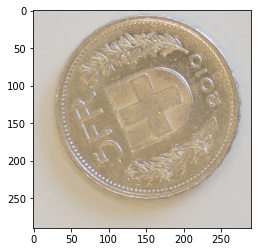

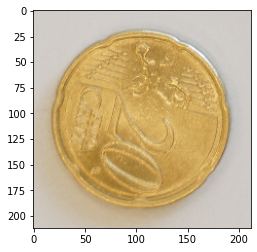

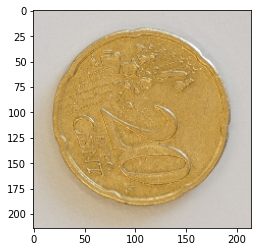

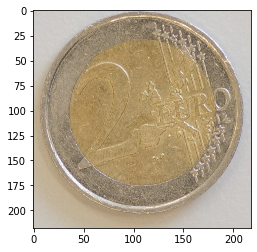

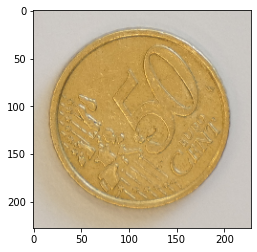

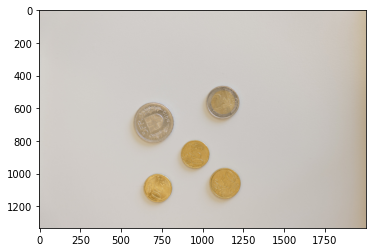

In [11]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
d = "./data/train/5. noisy_bg_outliers/"
# d = "./data/train/6. hand_outliers///"
# d = "./data/test//"
# for f in os.listdir(d):

paths = get_training_data_paths()
p = paths[0]
if get_label_for_image(p).shape[0] == 0:
    print("wrong filename")

circles = find_circles(paths[0], debug=True)
# for path in get_training_data_paths():
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
# img[:, :, 1] = 0



In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
def extract_features(input_image):
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    model.eval()
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    input_image = Image.fromarray(input_image)
    # input_image.show()
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
   
    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    features = torch.flatten(features)
    # print(features.size())
    return features




Using cuda for inference


Using cache found in C:\Users\iab_b/.cache\torch\hub\pytorch_vision_v0.10.0


In [13]:
for circle in circles:
    extract_features(circle)

In [14]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 17), 
    torch.nn.Softmax(dim=1) 
)

linear = linear.to(device)


In [15]:
# for circle in circles:
#     # extract_features(circle)
#     x = extract_features(circle)
#     x = torch.unsqueeze(x, 0)

#     y = linear(x).flatten()
#     # y.flatten()
#     print(y)
#     pred += y
# print(pred)

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1) 
  
paths = get_training_data_paths()


for path in paths:
    pred = torch.zeros(17).to(device)
    
    label = get_label_for_image(path).to(device)
    label = label/torch.count_nonzero(label)
    if label.shape[0] == 0:
        print("wrong filename") 
        continue
    
    circles = find_circles(path)
    feat = torch.zeros(2048).to(device)
    for circle in circles:
    # extract_features(circle)
        with torch.no_grad():
            x = extract_features(circle)
            feat+=x
            # x = torch.unsqueeze(x, 0)

    pred = linear(torch.unsqueeze(feat, 0)).flatten()
    
    # y.flatten()
    # print(y)
    # with torch.no_grad():
    # pred 
        # pred[torch.argmax(y)]+=1
    
    print(torch.max(pred))
    # pred = torch.unsqueeze(pred, 0)
    # print(label)
    # print(f"label: {label.shape}")
    # print(f"pred {pred.shape}")
    loss = criterion(pred, label) 
  
    # Backward pass and optimization 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
  
    print(loss)
    

detected 5 circles
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0551, device='cuda:0', grad_fn=<MseLossBackward>)
detected 4 circles
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0735, device='cuda:0', grad_fn=<MseLossBackward>)
detected 8 circles
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1250, device='cuda:0', grad_fn=<MseLossBackward>)
detected 6 circles
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0776, device='cuda:0', grad_fn=<MseLossBackward>)
detected 8 circles
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0708, device='cuda:0', grad_fn=<MseLossBackward>)
detected 5 circles
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0706, device='cuda:0', grad_fn=<MseLossBackward>)
detected 5 circles
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward>)
detected 4 circles
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(

In [22]:
def get_test_data_paths():
    test_paths = []
    base_dir = "./data/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
            # print(file_path)
    return test_paths



In [27]:
test_paths = get_test_data_paths()
circles = find_circles(test_paths[0], debug=False)
pred = torch.zeros(17).to(device)

for circle in circles:
    # extract_features(circle)
        
    x = extract_features(circle)
    x = torch.unsqueeze(x, 0)

    y = linear(x).flatten()
    # print(y)
    pred[torch.argmax(y)]+=1
    # y.flatten()
    # print(y)
    # with torch.no_grad():
    # pred += y

print(pred)
    


detected 4 circles
tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
